In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import glob
import itertools
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [4]:
sys.path.append("../../..")

In [5]:
from bertrand.model.tokenization import AA_list
from bertrand.negative_decoys.basic_filtering import (
    basic_filtering as basic_filtering_bertrand,
)
from bertrand.negative_decoys.basic_filtering import (
    read_positives_and_group_by_tcr,
    read_reference_tcrs,
)

In [686]:
cdrcols = ['CDR3a_extended', 'CDR3b_extended']

In [6]:
test = pd.read_csv("../../../data/immrep/test.csv")

In [7]:
test.shape

(3484, 17)

In [8]:
test.columns

Index(['ID', 'Peptide', 'HLA', 'Va', 'Ja', 'TCRa', 'CDR1a', 'CDR2a', 'CDR3a',
       'CDR3a_extended', 'Vb', 'Jb', 'TCRb', 'CDR1b', 'CDR2b', 'CDR3b',
       'CDR3b_extended'],
      dtype='object')

In [9]:
test.head(3)

,ID,Peptide,HLA,Va,Ja,TCRa,CDR1a,CDR2a,CDR3a,CDR3a_extended,Vb,Jb,TCRb,CDR1b,CDR2b,CDR3b,CDR3b_extended
0,0,SALPTNADLY,A*01:01,TRAV8-3*01,TRAJ21*01,MLLELIPLLGIHFVLRTARAQSVTQPDIHITVSEGASLELRCNYSY...,YGATPY,YFSGDTLV,AVGDNFNKFY,CAVGDNFNKFYF,TRBV28*01,TRBJ2-7*01,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,MDHEN,SYDVKM,ASAPTSAMGEQY,CASAPTSAMGEQYF
1,1,IPSINVHHY,B*35:01,TRAV30*01,TRAJ26*01,METLLKVLSGTLLWQLTWVRSQQPVQSPQAVILREGEDAVINCSSS...,KALYS,LLKGGEQ,GTYDNYGQNFV,CGTYDNYGQNFVF,TRBV7-3*01,TRBJ2-3*01,MGTRLLCWAALCLLGADHTGAGVSQTPSNKVTEKGKYVELRCDPIS...,SGHTA,FQGTGA,ASSRLAGGVGDTQY,CASSRLAGGVGDTQYF
2,2,GLCTLVAML,A*02:01,TRAV5*01,TRAJ23*01,MKTFAGFSFLFLWLQLDCMSRGEDVEQSLFLSVREGDSSVINCTYT...,DSSSTY,IFSNMDM,AESIGKLI,CAESIGKLIF,TRBV29-1*01,TRBJ1-4*01,MLSLLLLLLGLGSVFSAVISQKPSRDICQRGTSLTIQCQVDSQVTM...,SQVTM,ANQGSEA,SVGTGGTNEKLF,CSVGTGGTNEKLFF


In [15]:
def diagnostics(train):
    print(f"{len(train)} examples")
    m = train.CDR3a_extended.isin(test.CDR3a_extended) | train.CDR3b_extended.isin(test.CDR3b_extended)
    print(f"{(~m).sum()} usable examples, {m.sum()} in limbo")
    print("### CDR")
    print("Length disribution")
    a = train.CDR3a_extended.str.len().value_counts().sort_index()
    b = train.CDR3b_extended.str.len().value_counts().sort_index()
    j = pd.concat([a, b], axis=1).fillna(0).astype(int)
    j.index = j.index.astype(int)
    print(j)

    nad = len(train.CDR3a_extended.drop_duplicates())
    nbd = len(train.CDR3b_extended.drop_duplicates())
    nnd = len(train[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates())

    print(f"{nad} CDR3a unique in {len(train)}")
    print(f"{nbd} CDR3b unique in {len(train)}")
    print(f"{nnd} unique CDR3a,CDR3b pairs in {len(train)}")

    print("### Peptide")
    pvc = train.Peptide.value_counts()
    print(f"{len(pvc)} unique peptides")
    for top in [5, 10, 15]:
        top5 = pvc.head(top).sum() / len(train)
        print(f"{top5:.2f} observations in top {top} peptides")

    print("Test set peptides present")
    print("Observations for test peptides")
    print(test.Peptide.drop_duplicates().isin(train.Peptide).value_counts().sort_index())
    td = train[train.Peptide.isin(test.Peptide)]

    print(td.Peptide.value_counts())

    cols = ["CDR3a_extended", "CDR3b_extended"]
    test_index = pd.MultiIndex.from_frame(test[cols])
    train_index = pd.MultiIndex.from_frame(train[cols])
    s = test_index.isin(train_index).sum()
    print(f"{s} exact test observations in train")

    print("### HLA")
    print(train.HLA.value_counts().head(10))

In [16]:
diagnostics(test)

3484 examples
0 usable examples, 3484 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
7                2               0
8                6               0
9               10              25
10              54               9
11             305              58
12             570             213
13             647             813
14             796             739
15             622             675
16             275             544
17             145             260
18              36              75
19               8              45
20               5               7
21               1              19
24               2               0
22               0               2
637 CDR3a unique in 3484
632 CDR3b unique in 3484
727 unique CDR3a,CDR3b pairs in 3484
### Peptide
20 unique peptides
0.51 observations in top 5 peptides
0.75 observations in top 10 peptides
0.89 observations in top 15 peptides
Test set peptides present
Observations for test peptides
True    20


In [17]:
train_immrep3 = pd.read_csv("../../../data/immrep/VDJdb_paired_chain.csv")

In [18]:
diagnostics(train_immrep3)

11312 examples
10035 usable examples, 1277 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
5                4               0
6                4               0
7               13               1
8               20               3
9               65               8
10             440              54
11            1145             297
12            1828             777
13            2261            2866
14            2036            2357
15            1872            2324
16             806            1379
17             523             740
18             177             291
19              64             146
20              24              51
21              23              11
22               3               2
23               1               3
24               1               0
25               0               2
8651 CDR3a unique in 11312
8993 CDR3b unique in 11312
11140 unique CDR3a,CDR3b pairs in 11312
### Peptide
808 unique peptides
0.44 observations in top 

In [19]:
be = pd.read_parquet("../../../data/binding-estimation")

In [20]:
be.shape

(5170369, 43)

In [21]:
binders = be[be.is_binder]

In [22]:
pd.crosstab(binders.CDR3_alpha.isna(), binders.CDR3_beta.isna())

CDR3_beta,False,True
CDR3_alpha,,
False,28559,7297
True,38533,2


In [23]:
alpha_beta_binders = binders[~binders.CDR3_beta.isna() & ~binders.CDR3_alpha.isna()]

In [24]:
alpha_beta_binders.reference_id.value_counts().head(20)

https://www.jimmunol.org/content/202/1_Supplement/131.4              13644
10x CMV                                                               2737
PMID:34793243                                                         1816
PMID:30479382                                                          963
PMID:34341799|https://github.com/antigenomics/vdjdb-db/issues/326      764
PMID:28636592                                                          754
ardigen_healthy/donor_12                                               693
ardigen_healthy/donor_6                                                648
PMID:35750048                                                          641
ardigen_healthy/donor_8                                                492
ardigen_healthy/donor_10                                               452
ardigen_healthy/donor_4                                                434
PMID:28103239                                                          296
ardigen_healthy/donor_9  

In [25]:
alpha_beta_binders.shape

(28559, 43)

In [26]:
train_immuno = alpha_beta_binders.rename(
    columns={"CDR3_alpha": "CDR3a_extended", "CDR3_beta": "CDR3b_extended", "HLA": "HLA_pseudoseq", "HLA_type": "HLA"}
)

In [27]:
train_immuno_wo_10x = train_immuno[train_immuno.reference_id != train_immuno.reference_id.value_counts().index[0]]

In [28]:
diagnostics(train_immuno)

28559 examples
26944 usable examples, 1615 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
8               95               6
9              147              16
10             984             115
11            2637             886
12            4590            2124
13            5570            5926
14            5435            5869
15            4610            6444
16            2361            3759
17            1389            1924
18             451             853
19             200             429
20              55             121
21              20              60
22              12              21
23               1               5
25               2               0
24               0               1
17042 CDR3a unique in 28559
18279 CDR3b unique in 28559
20496 unique CDR3a,CDR3b pairs in 28559
### Peptide
1057 unique peptides
0.50 observations in top 5 peptides
0.63 observations in top 10 peptides
0.70 observations in top 15 peptides
Test set peptides

In [29]:
diagnostics(train_immuno_wo_10x)

14915 examples
14038 usable examples, 877 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
8               41               4
9               97              13
10             678              64
11            1626             458
12            2479            1153
13            2749            3152
14            2772            3196
15            2359            3326
16            1221            1921
17             554             945
18             211             388
19              94             192
20              18              67
21               6              29
22               9               5
23               1               2
10114 CDR3a unique in 14915
10783 CDR3b unique in 14915
11580 unique CDR3a,CDR3b pairs in 14915
### Peptide
1042 unique peptides
0.29 observations in top 5 peptides
0.43 observations in top 10 peptides
0.55 observations in top 15 peptides
Test set peptides present
Observations for test peptides
False     6
True     14
Name: P

In [30]:
import glob

df_list = []
for fn in glob.glob("../../../data/immrep22/true_set/*.txt"):
    peptide = os.path.splitext(os.path.basename(fn))[0]

    print(peptide)
    df = pd.read_csv(fn, sep="\t")
    if "Global" in peptide:
        df = df.rename(columns={"Epitope_GroundTruth": "Peptide"})
        # continue
    else:
        df["Peptide"] = peptide
    df["HLA"] = ""
    df = df.rename(columns={"TRB_CDR3": "CDR3b_extended", "TRA_CDR3": "CDR3a_extended"})
    df_list.append(df)


train_immrep22 = pd.concat(df_list).reset_index(drop=True)
diagnostics(train_immrep22)

GILGFVFTL
LTDEMIAQY
YLQPRTFLL
NLVPMVATV
NYNYLYRLF
KSKRTPMGF
SPRWYFYYL
RAQAPPPSW
GLCTLVAML
testSet_Global
LLWNGPMAV
GPRLGVRAT
HPVTKYIM
TTDPSFLGRY
CINGVCWTV
ATDALMTGF
TPRVTGGGAM
NQKLIANQF
4294 examples
3886 usable examples, 408 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
6                2               0
7                6               2
8               11               1
9               26               0
10             206               9
11             555             123
12             739             311
13             725            1119
14             791             887
15             662             852
16             315             551
17             178             264
18              60             113
19              15              34
20               2              23
21               1               5
2661 CDR3a unique in 4294
2729 CDR3b unique in 4294
2946 unique CDR3a,CDR3b pairs in 4294
### Peptide
17 unique peptides
0.60 observations in t

In [31]:
# import glob

# df_list = []
# for fn in glob.glob("../../../../vdjdb-db/chunks/*.txt"):

#     df = pd.read_csv(fn, sep="\t")
#     raise Exception()
#     # df['HLA'] = ''
#     df = df.rename(columns={"TRB_CDR3": "CDR3b_extended", "TRA_CDR3": "CDR3a_extended"})
#     df_list.append(df)


# train_immrep22 = pd.concat(df_list).reset_index(drop=True)
# diagnostics(train_immrep22)

In [777]:
train_vdjdb = pd.read_csv("../../../data/vdjdb/vdjdb_full.txt", sep="\t")

/tmp/ipykernel_3641/1700424722.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  train_vdjdb = pd.read_csv("../../../data/vdjdb/vdjdb_full.txt", sep="\t")


In [812]:
train_vdjdb = train_vdjdb.rename(
    columns={
        "cdr3.alpha": "CDR3a_extended",
        "cdr3.beta": "CDR3b_extended",
        "mhc.a": "HLA",
        "antigen.epitope": "Peptide",
    }
)

In [813]:
train_vdjdb.iloc[0]

CDR3a_extended                                               CIVRAPGRADMRF
v.alpha                                                        TRAV26-1*01
j.alpha                                                          TRAJ43*01
CDR3b_extended                                        CASSYLPGQGDHYSNQPQHF
v.beta                                                           TRBV13*01
d.beta                                                                 NaN
j.beta                                                          TRBJ1-5*01
species                                                        HomoSapiens
HLA                                                               HLA-B*08
mhc.b                                                                  B2M
mhc.class                                                             MHCI
Peptide                                                           FLKEKGGL
antigen.gene                                                           Nef
antigen.species          

In [815]:
train_vdjdb = train_vdjdb[
    ~train_vdjdb.CDR3a_extended.isna()
    & ~train_vdjdb.CDR3b_extended.isna()
    & (train_vdjdb.species == "HomoSapiens")
    & (train_vdjdb["mhc.class"] == "MHCI")
]

In [36]:
diagnostics(train_vdjdb)

27571 examples
25760 usable examples, 1811 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
5                1               0
6                4               0
7                8               0
8               80               9
9              136              17
10             836             127
11            2437             796
12            4519            1969
13            5395            5683
14            5208            5575
15            4530            6248
16            2273            3633
17            1453            2015
18             447             885
19             173             382
20              38             150
21              15              52
22               9              17
23               2               7
24               3               1
25               3               2
26               1               3
19862 CDR3a unique in 27571
21232 CDR3b unique in 27571
25074 unique CDR3a,CDR3b pairs in 27571
### Peptide
830 uniq

In [37]:
# my_data = pd.read_csv("../../../data/phla_tcr_all.csv.gz")

# my_data[~my_data.CDR3a.isna() & ~my_data.CDR3b.isna()].shape

In [38]:
def get_test_counts(train):
    return train.Peptide[train.Peptide.isin(test.Peptide)].value_counts()  # .fillna(0).astype(int)

In [39]:
stats = (
    pd.concat(
        [
            get_test_counts(train)
            for train in [train_immrep3, train_immuno, train_immuno_wo_10x, train_immrep22, train_vdjdb]
        ],
        axis=1,
    )
    .fillna(0)
    .astype(int)
)

In [40]:
stats.columns = ["immrep3", "immuno", "immuno wo 10x", "immrep22", "vdjdb"]

In [42]:
stats

,immrep3,immuno,immuno wo 10x,immrep22,vdjdb
GILGFVFTL,1818,2217,1296,948,2194
RAKFKQLL,1066,985,258,0,1235
YLQPRTFLL,434,397,397,466,472
NLVPMVATV,390,714,713,480,588
GLCTLVAML,351,661,590,257,394
IVTDFSVIK,332,856,8,0,729
TPRVTGGGAM,62,377,376,81,63
RPPIFIRRL,45,341,340,0,36
RPHERNGFTVL,27,294,293,0,29
EPLPQGQLTAY,14,9,9,0,15


In [43]:
from Levenshtein import distance


def broad_negatives(train, test):
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    peps = pos.Peptide.drop_duplicates()
    peps.index = peps.values
    rlist = []

    for i, pep in enumerate(pos.loc[pos.Peptide.isin(test.Peptide), "Peptide"].value_counts().index):
        pep_positives = pos[pos.Peptide == pep].copy()
        if len(pep_positives) < 10:
            continue
        if len(pep_positives) > 100:
            pep_positives = pep_positives.sample(100, random_state=i)
        pep_positives["y"] = 1
        # print(len(pep_positives))

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]
        train_neg = pos[pos.Peptide.isin(pep_potential_negatives)]
        train_neg_tcrs = train_neg[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates()
        # print(len(train_neg_tcrs))

        sample_negs = train_neg_tcrs.sample(n=int(len(pep_positives) * 5), random_state=i)
        sample_negs["Peptide"] = pep
        sample_negs["y"] = 0

        rlist.append(pd.concat([pep_positives, sample_negs]))
    return pd.concat(rlist)

In [44]:
# from Levenshtein import distance
def narrow_negatives(train, test):
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()

    vc = pos.loc[pos.Peptide.isin(test.Peptide), "Peptide"].value_counts()
    peps = pd.Series(vc.index[vc >= 10], index=vc.index[vc >= 10])
    rlist = []

    for i, pep in enumerate(peps.index):
        # print(pep)
        pep_positives = pos[pos.Peptide == pep].copy()
        if len(pep_positives) < 10:
            raise Exception()
            continue
        if len(pep_positives) > 100:
            pep_positives = pep_positives.sample(100, random_state=i)
        pep_positives["y"] = 1
        # print(len(pep_positives))

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]
        train_neg = pos[pos.Peptide.isin(pep_potential_negatives)]
        train_neg_tcrs = train_neg[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates()
        # print(len(train_neg_tcrs))

        sample_negs = train_neg_tcrs.sample(n=int(len(pep_positives) * 5), random_state=i)
        sample_negs["Peptide"] = pep
        sample_negs["y"] = 0

        rlist.append(pd.concat([pep_positives, sample_negs]))
    return pd.concat(rlist)

In [45]:
def narrow_negatives2(train, test):
    T = 150

    def sample(df):
        if len(df) <= 10:
            return None
        if len(df) >= T:
            return df.sample(T)
        return df

    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    train_sample = pos.loc[pos.Peptide.isin(test.Peptide)].groupby("Peptide").apply(sample).reset_index(drop=True)

    vc = train_sample.loc[train_sample.Peptide.isin(test.Peptide), "Peptide"].value_counts()
    peps = pd.Series(vc.index[vc >= 10], index=vc.index[vc >= 10])
    rlist = []

    for i, pep in enumerate(peps.index):
        # print(pep)
        pep_positives = train_sample[train_sample.Peptide == pep].copy()
        if len(pep_positives) < 10:
            raise Exception()
            continue
        if len(pep_positives) > T:
            raise Exception()
            pep_positives = pep_positives.sample(100, random_state=i)
        pep_positives["y"] = 1
        # print(len(pep_positives))

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]
        train_neg = train_sample[train_sample.Peptide.isin(pep_potential_negatives)]
        train_neg_tcrs = train_neg[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates()
        # print(len(train_neg_tcrs))

        sample_negs = train_neg_tcrs.sample(n=int(len(pep_positives) * 5), random_state=i)
        sample_negs["Peptide"] = pep
        sample_negs["y"] = 0

        rlist.append(pd.concat([pep_positives, sample_negs]))
    return pd.concat(rlist)

In [1019]:
def narrow_negatives3(train, test, frac=0.2):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()

    pos = pos[pos.Peptide.isin(test.Peptide)]

    # pos.shape

    potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=frac)).reset_index(drop=True)

    # potential_tcr_negatives = pos

    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        pep_positives = pos[pos.Peptide == pep].copy()
        pep_positives["y"] = 1

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        len(potential_tcr_negatives)

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        # train_neg = train_neg[['CDR3a_extended', 'CDR3b_extended']].drop_duplicates()

        sample_neg = train_neg.sample(min(len(pep_positives) * 5, len(train_neg)), replace=False)

        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0

        T = 85
        if len(pep_positives) > T:
            pep_positives = pep_positives.sample(T)
            sample_neg = sample_neg.sample(T * 5)
        rlist.append(pd.concat([pep_positives, sample_neg]))
    df = pd.concat(rlist)
    # df = df.drop_duplicates()
    df = df.groupby(['Peptide']+cdrcols).y.agg(max).reset_index()
    return df

In [47]:
def narrow_negatives4(train, test):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()

    pos = pos[pos.Peptide.isin(test.Peptide)]

    # pos.shape

    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=0.25)).reset_index(drop=True)

    # potential_tcr_negatives = pos

    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    peps = pd.Series(peps, index=peps)
    rlist = []

    plist = []
    for i, pep in enumerate(peps.index):
        pep_positives = pos[pos.Peptide == pep].copy()
        pep_positives["y"] = 1
        T = 80
        if len(pep_positives) > T:
            pep_positives = pep_positives.sample(T)

        plist.append(pep_positives)

    potential_tcr_negatives = pd.concat(plist)

    for i, (pep, pep_positives) in enumerate(zip(peps.index, plist)):
        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        # train_neg = train_neg[['CDR3a_extended', 'CDR3b_extended']].drop_duplicates()
        #         print(pep, train_neg.shape)

        #         pos_index = pd.MultiIndex.from_frame(
        #             potential_tcr_negatives.loc[
        #                 potential_tcr_negatives.Peptide != pep, ["CDR3a_extended", "CDR3b_extended", "Peptide"]
        #             ]
        #         )
        #         neg_index = pd.MultiIndex.from_frame(train_neg[["CDR3a_extended", "CDR3b_extended", "Peptide"]])
        #         train_neg = train_neg[~neg_index.isin(pos_index)]
        #         print(pep, train_neg.shape)
        sample_neg = train_neg.sample(len(pep_positives) * 5, replace=False)
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0

        rlist.append(
            pd.concat(
                [
                    pep_positives,
                    sample_neg,
                ]
            )
        )
    return pd.concat(rlist)

In [89]:
def cross_negatives(train, test):
    T = 110

    def sample(df):
        if len(df) <= 10:
            return None
        if len(df) >= T:
            return df.sample(T)
        return df

    pos = train.loc[train.Peptide.isin(test.Peptide)]
    pos = pos[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos.groupby("Peptide").apply(sample).reset_index(drop=True)

    vc = pos.Peptide.value_counts()
    # print(vc)
    peps = pd.Series(vc.index[vc >= 10], index=vc.index[vc >= 10])
    neg_i_list = []

    rlist = []
    for i, pep in enumerate(pos.Peptide.value_counts().index):
        # print(pep)
        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]
        pep_positives = pos[pos.Peptide == pep].copy()
        if len(pep_positives) < 10:
            continue
        pep_positives["y"] = 1

        train_neg = pep_positives[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates()
        train_neg["dummy"] = 1

        pep_neg = pd.DataFrame(pep_potential_negatives).rename(columns={0: "Peptide"})
        pep_neg["dummy"] = 1
        neg = pd.merge(train_neg, pep_neg, how="outer").drop(columns=["dummy"])
        neg["dummy"] = 1
        neg["y"] = 0

        neg_i = pd.MultiIndex.from_frame(neg[["Peptide", "CDR3a_extended", "CDR3b_extended"]])
        pos_i = pd.MultiIndex.from_frame(pos[["Peptide", "CDR3a_extended", "CDR3b_extended"]])
        neg = neg[~neg_i.isin(pos_i)]

        neg_i = pd.MultiIndex.from_frame(neg[["Peptide", "CDR3a_extended", "CDR3b_extended"]])
        if len(neg_i_list) > 0:
            neg_i_c = pd.MultiIndex.from_frame(pd.concat([i.to_frame() for i in neg_i_list]))
            neg = neg[~neg_i.isin(neg_i_c)]
        neg_i_list.append(neg_i)

        rlist.append(pd.concat([pep_positives, neg]))
    df = pd.concat(rlist).reset_index(drop=True)
    return df

In [122]:
def resample(df, T=100):
    rlist = []
    for k, gdf in df.groupby("Peptide"):
        sample_pos = gdf[gdf.y == 1]
        if len(sample_pos) > T:
            sample_pos = sample_pos.sample(T)

        sample_neg = gdf[gdf.y == 0]
        if len(sample_neg) > len(sample_pos) * 5:
            sample_neg = sample_neg.sample(len(sample_pos) * 5)

        rlist.append(pd.concat([sample_pos, sample_neg]))
    return pd.concat(rlist).reset_index(drop=True)

In [753]:
def narrow_negatives5(train, test):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]

    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    peps = pd.Series(peps, index=peps)
    rlist = []

    plist = []
    for i, pep in enumerate(peps.index):
        pep_positives = pos[pos.Peptide == pep].copy()
        pep_positives["y"] = 1
        T = 85
        if len(pep_positives) > T:
            pep_positives = pep_positives.sample(T)

        plist.append(pep_positives)

    potential_tcr_negatives = pd.concat(plist)

    for i, (pep, pep_positives) in enumerate(zip(peps.index, plist)):
        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]
        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        print(pep, len(pep_positives), len(train_neg))
        n = min(len(train_neg), len(pep_positives) * 5)
        sample_neg = train_neg.sample(n, replace=False)
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0

        rlist.append(
            pd.concat(
                [
                    pep_positives,
                    sample_neg,
                ]
            )
        )
    df = pd.concat(rlist)
    df = df.drop_duplicates()
    df = resample(df, T=80)
    return df

In [355]:
def narrow_negatives6(train, test):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()

    pos = pos[pos.Peptide.isin(test.Peptide)]

    # pos.shape

    potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=0.15)).reset_index(drop=True)
    # print(potential_tcr_negatives.shape)
    # raise Exception()
    # potential_tcr_negatives = pos

    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        pep_positives = potential_tcr_negatives[potential_tcr_negatives.Peptide == pep].copy()
        pep_positives["y"] = 1

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        # len(potential_tcr_negatives)

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        # train_neg = train_neg[['CDR3a_extended', 'CDR3b_extended']].drop_duplicates()

        n = min(len(pep_positives) * 5, len(train_neg))
        sample_neg = train_neg.sample(n, replace=False)

        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0

        # T = 80
        # if len(pep_positives) > T:
        #     pep_positives = pep_positives.sample(T)
        #     if len(sample_neg) > T * 5:
        #         sample_neg = sample_neg.sample(T * 5)
        rlist.append(pd.concat([pep_positives, sample_neg]))
    df = pd.concat(rlist)
    df = df.drop_duplicates()
    return df

In [735]:
synthetic_test = narrow_negatives5(train_vdjdb, test)

GILGFVFTL 85 587
RAKFKQLL 85 587
IVTDFSVIK 85 587
YLQPRTFLL 85 587
NLVPMVATV 85 587
GLCTLVAML 85 587
TPRVTGGGAM 61 611
RPPIFIRRL 36 636
RPHERNGFTVL 29 643
EPLPQGQLTAY 14 658
YVLDHLIVV 12 660
IPSINVHHY 10 662


### Matrix

In [290]:
pos = train.loc[train.Peptide.isin(test.Peptide)]
pos = pos[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
vc = pos.Peptide.value_counts()
possible_peptides = vc.index[vc >= 10]
pos = pos[pos.Peptide.isin(possible_peptides)]

GILGFVFTL      1900
RAKFKQLL       1216
IVTDFSVIK       718
YLQPRTFLL       443
NLVPMVATV       416
GLCTLVAML       364
TPRVTGGGAM       61
RPPIFIRRL        36
RPHERNGFTVL      29
EPLPQGQLTAY      14
YVLDHLIVV        12
IPSINVHHY        10
Name: Peptide, dtype: int64

In [360]:
TCR = pos[["CDR3a_extended", "CDR3b_extended"]].drop_duplicates()

In [361]:
PEP = pos.Peptide.drop_duplicates()

In [362]:
matrix = pd.DataFrame(index=PEP, columns=pd.MultiIndex.from_frame(TCR))

In [363]:
for pep in PEP:
    pos_pep = pd.MultiIndex.from_frame(pos.loc[pos.Peptide == pep, ["CDR3a_extended", "CDR3b_extended"]])
    matrix.loc[pep, pos_pep] = 1
    other_peps = PEP[PEP.apply(lambda p: distance(p, pep) > 3)]
    print(len(other_peps))
    matrix.loc[other_peps, pos_pep] = 0
    # other_peps =

11
11
11
11
11
11
11
11
11
11
11
11


In [366]:
synthetic_test = matrix.unstack().reset_index().rename(columns={0: "y"})

In [302]:
synthetic_test = resample(synthetic_test, T=80)

In [677]:
def pep_sample_negatives1(train, test):
    pos = train.loc[train.Peptide.isin(test.Peptide)]
    pos = pos[["CDR3a_extended", "CDR3b_extended", "Peptide"]].drop_duplicates()
    pos["y"] = 1
    pos_subsample = resample(pos, T=80)

    vc = pos_subsample.Peptide.value_counts(normalize=True)
    pos_subsample_i = pos_subsample.set_index(["CDR3a_extended", "CDR3b_extended"])
    rlist = []
    for _, cdr_row in pos_subsample[["CDR3a_extended", "CDR3b_extended"]].iterrows():
        cdra, cdrb = cdr_row
        peptides = pos_subsample_i.loc[cdra].loc[cdrb].Peptide
        other_peps = PEP[PEP.apply(lambda p: all([distance(p, pep) > 3 for pep in peptides]))]
        p = vc.loc[other_peps]
        p = p / p.sum()
        pep_sample = np.random.choice(other_peps, size=5, p=p)
        neg_sample = pd.DataFrame(data={"Peptide": pep_sample})
        neg_sample["CDR3a_extended"] = cdra
        neg_sample["CDR3b_extended"] = cdrb
        neg_sample["y"] = 0
        rlist.append(neg_sample)

    df = pd.concat(rlist)
    df = pd.concat([pos_subsample, df])
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [678]:

def pep_sample_negatives2(train, test):
    pos = train.loc[train.Peptide.isin(test.Peptide)]
    pos = pos[["CDR3a_extended", "CDR3b_extended", "Peptide"]].drop_duplicates()
    pos["y"] = 1
    pos_subsample = resample(pos, T=80)
    vc = pos_subsample.Peptide.value_counts(normalize=True)
    neg_pep = np.random.choice(vc.index, size=len(pos_subsample) * 5, replace=True, p=vc)
    neg_tcr = pos_subsample[["CDR3a_extended", "CDR3b_extended"]].sample(n=len(neg_pep), replace=True)
    neg = pd.concat([pd.Series(neg_pep, index=neg_tcr.index, name="Peptide"), neg_tcr], axis=1).reset_index(drop=True)
    neg = neg.drop_duplicates()
    pos_index = pd.MultiIndex.from_frame(pos_subsample[["Peptide", "CDR3a_extended", "CDR3b_extended"]])
    neg = neg[~pd.MultiIndex.from_frame(neg).isin(pos_index)].copy()
    neg["y"] = 0
    df = pd.concat([pos_subsample, neg])
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [ ]:
train_vdjdb['CDR3

In [912]:
def narrow_negatives7(train, test, start_resample=150, end_resample=80, replace=True, ratio = True):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()

    pos = pos[pos.Peptide.isin(test.Peptide)]
    pos = pos.drop_duplicates()
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]
    
    pos['y']= 1
    
    # print(pos)

    # pos.shape
    
    if start_resample:
        if isinstance(start_resample, int):
            pos_sample = resample(pos, T=start_resample)
        elif isinstance(start_resample, float):
            pos_sample = pos.groupby("Peptide").apply(lambda x: x.sample(frac=start_resample) if len(x) > 10/start_resample else x).reset_index(drop=True)
    else:
        pos_sample = pos
        
    # pos_sample = pos

    
    peps = pd.Series(peps, index=peps)
    rlist = []
    pos_i = pd.MultiIndex.from_frame(pos_sample[cdrcols +['Peptide']])

    for i, pep in enumerate(peps.index):
        pep_positives = pos_sample[pos_sample.Peptide == pep].copy()
        # print(len(pep_positives))
        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        # len(potential_tcr_negatives)

        train_neg = pos_sample[pos_sample.Peptide.isin(pep_potential_negatives)].copy()
        train_neg['Peptide'] = pep
        # print(train_neg.head())
        neg_i = pd.MultiIndex.from_frame(train_neg[cdrcols+['Peptide']])
        train_neg = train_neg[~neg_i.isin(pos_i)]
        train_neg = train_neg[['CDR3a_extended', 'CDR3b_extended']].drop_duplicates()
        # print(len(pep_positives), len(train_neg))
        n = len(pep_positives) * 5
        if not replace:
            n = min(len(pep_positives) * 5, len(train_neg))
        sample_neg = train_neg.sample(n, replace=replace)        
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0

        # T = 80
        # if len(pep_positives) > T:
        #     pep_positives = pep_positives.sample(T)
        #     if len(sample_neg) > T * 5:
        #         sample_neg = sample_neg.sample(T * 5)
        # print(len(pep_positives), len(sample_neg))
        # print(pep_positives.head())
        # print(sample_neg.head())
        rlist.append(pd.concat([pep_positives, sample_neg]))
        # raise Exception()
    df = pd.concat(rlist)
    df = df.drop_duplicates()
    
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    if end_resample:
        return resample(df, T=end_resample)
    return df

In [1000]:
synthetic_test = narrow_negatives7(train_vdjdb, test, start_resample=0.1, end_resample=90, replace=False)

In [1824]:
def narrow_negatives9(train, test, T=80):
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]
    pos['y'] = 1
    # T = 80
    # pos_sample = pos.groupby("Peptide").apply(lambda x: x.sample(frac=frac) if len(x) >= 10/frac else x).reset_index(drop=True)
    pos_sample = pos.groupby("Peptide").apply(lambda x: x.sample(n=T) if len(x) >= T else x).reset_index(drop=True)
    # print(pos_sample.shape)
    # pos_sample['y'] = 1 
    # print(pos_sample.Peptide.value_counts())

    rlist = []
    for pep in pos.Peptide.value_counts().index:
        # print(pep)
        pos_i = pd.MultiIndex.from_frame(pos.loc[pos.Peptide == pep, cdrcols])
        pos_pep = pos[pos.Peptide == pep]
        if len(pos_pep) > T:
            pos_pep = pos_pep.sample(T)
            
    
        neg = pos_sample[pos_sample.Peptide != pep]
        neg_i = pd.MultiIndex.from_frame(neg[cdrcols])
        neg = neg[~neg_i.isin(pos_i)]
        print(len(pos_pep), len(neg))
        neg_sample = neg.sample(min(len(pos_pep)*5, len(neg)), replace=False)
        neg_sample['Peptide'] = pep
        neg_sample['y'] = 0
        
       
        
        rlist.append(pd.concat([pos_pep, neg_sample]))
    df = pd.concat(rlist)
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [1945]:
def narrow_negatives10(train, test, frac=0.2):
   

    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]

    frac = 0.2
    T = 400
    potential_tcr_negatives = pos
    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=frac) if len(x) >= 10/frac else x).reset_index(drop=True)
    potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(T) if len(x) >= T else x).reset_index(drop=True)

    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        pep_positives = potential_tcr_negatives[potential_tcr_negatives.Peptide == pep].copy()
        pep_positives["y"] = 1

        pos_i = pd.MultiIndex.from_frame(pos.loc[pos.Peptide == pep, cdrcols])
        # pep_positives = potential_tcr_negatives[potential_tcr_negatives.Peptide == pep].copy()

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        len(potential_tcr_negatives)

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        train_neg = train_neg[cdrcols].drop_duplicates()
        train_neg_i = pd.MultiIndex.from_frame(train_neg)
        train_neg = train_neg[~train_neg_i.isin(pos_i)]

        n = min(len(pep_positives) * 5, len(train_neg))

        sample_neg = train_neg.sample(n, replace=False)
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0
        rlist.append(pd.concat([pep_positives, sample_neg]))


    df = pd.concat(rlist)
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    unique_tcrs = df[cdrcols].drop_duplicates()
    test_tcrs = unique_tcrs.sample(frac=0.25)
    test_i = pd.MultiIndex.from_frame(test_tcrs)

    df_test = df[pd.MultiIndex.from_frame(df[cdrcols]).isin(test_i)]

    return df_test

In [1974]:
def narrow_negatives8(train, test, frac=0.2, fracneg=0.3):
    # train = train_vdjdb
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]

    # pos.shape
    
    potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=fracneg) if len(x) >= 10/fracneg else x).reset_index(drop=True)
    # print(potential_tcr_negatives.Peptide.value_counts())
    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=frac)).reset_index(drop=True)

    # potential_tcr_negatives = pos

    
    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        pep_positives = pos[pos.Peptide == pep].copy()
        pep_positives["y"] = 1

        pos_i = pd.MultiIndex.from_frame(pep_positives[cdrcols])
        # pep_positives = potential_tcr_negatives[potential_tcr_negatives.Peptide == pep].copy()

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        len(potential_tcr_negatives)

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        train_neg = train_neg[cdrcols].drop_duplicates()
        train_neg_i = pd.MultiIndex.from_frame(train_neg)
        train_neg = train_neg[~train_neg_i.isin(pos_i)]
        
        # T = 60
        # if len(pep_positives) > T:
        #     pep_positives = pep_positives.sample(T)
        if len(pep_positives) * frac > 10:
            # print('yo', len(pep_positives))
            # print(pep, len(pep_positives))
            pep_positives = pep_positives.sample(frac=frac, replace=False)
            # print('yo', len(pep_positives))
        # if len(pep_positives) > T:
        #     pep_positives = pep_positives.sample(T, replace=False)
            
        # print(len(pep_positives) * 5, len(train_neg))
        
        sample_neg = train_neg.sample(min(len(pep_positives) * 5, len(train_neg)), replace=False)

        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0
        print(pep, len(pep_positives), len(sample_neg))

        
        rlist.append(pd.concat([pep_positives, sample_neg]))
    df = pd.concat(rlist)
    # df = df.drop_duplicates()
    df = df.groupby(['Peptide']+cdrcols).y.agg(max).reset_index()
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [2052]:
synthetic_test = narrow_negatives8(train_immuno, test, frac=0.05, fracneg=0.09)
# synthetic_test = narrow_negatives8(train_vdjdb, test, frac=0.1)

GILGFVFTL 94 327
RAKFKQLL 49 245
IVTDFSVIK 43 215
NLVPMVATV 32 160
GLCTLVAML 29 145
YLQPRTFLL 20 100
TPRVTGGGAM 19 95
RPPIFIRRL 17 85
VTEHDTLLY 17 85
RPHERNGFTVL 15 75
YVLDHLIVV 22 110


## Basic comparison

In [2128]:
tt.shape

(2568, 17)

In [2129]:
synthetic_test.shape

(1999, 4)

In [2130]:
synthetic_test.y.value_counts()

0    1642
1     357
Name: y, dtype: int64

In [2131]:
synthetic_test.groupby(cdrcols).y.max().value_counts()

0    485
1    345
Name: y, dtype: int64

In [2132]:
m = synthetic_test.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
assert set(m) == {1}

In [2133]:
synthetic_test.Peptide.value_counts()

GILGFVFTL      421
RAKFKQLL       294
IVTDFSVIK      258
NLVPMVATV      192
GLCTLVAML      174
YVLDHLIVV      132
YLQPRTFLL      120
TPRVTGGGAM     114
RPPIFIRRL      102
VTEHDTLLY      102
RPHERNGFTVL     90
Name: Peptide, dtype: int64

In [2134]:
tt.Peptide.value_counts()

GILGFVFTL      526
RAKFKQLL       362
EPLPQGQLTAY    288
NLVPMVATV      258
YVLDHLIVV      204
VTEHDTLLY      150
GLCTLVAML      144
RPHERNGFTVL    114
IPSINVHHY       96
QIKVRVDMV       96
RPPIFIRRL       90
IVTDFSVIK       84
TPRVTGGGAM      78
YLQPRTFLL       78
Name: Peptide, dtype: int64

In [2135]:
tt.shape, synthetic_test.shape

((2568, 17), (1999, 4))

<AxesSubplot:xlabel='CDR3a_extended,CDR3b_extended'>

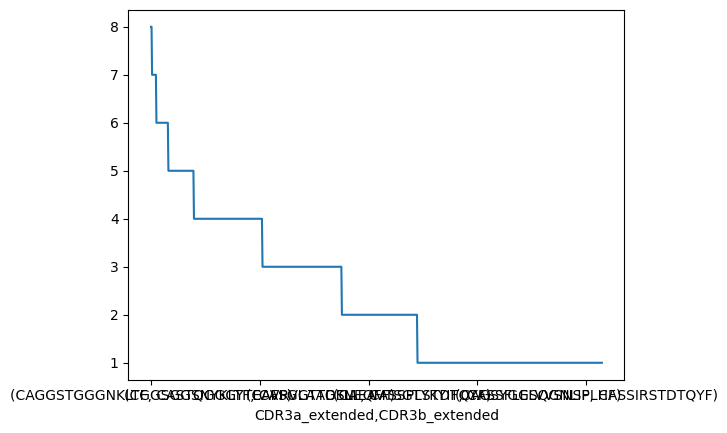

In [2136]:
synthetic_test[["CDR3a_extended", "CDR3b_extended"]].value_counts().plot()

<AxesSubplot:>

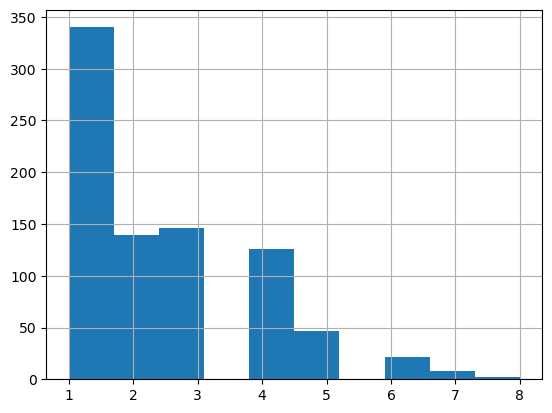

In [2137]:
synthetic_test[["CDR3a_extended", "CDR3b_extended"]].value_counts().hist()

In [2138]:
vc = train_vdjdb.Peptide.value_counts()
tt = test[test.Peptide.isin(vc[vc>=10].index)]

<AxesSubplot:>

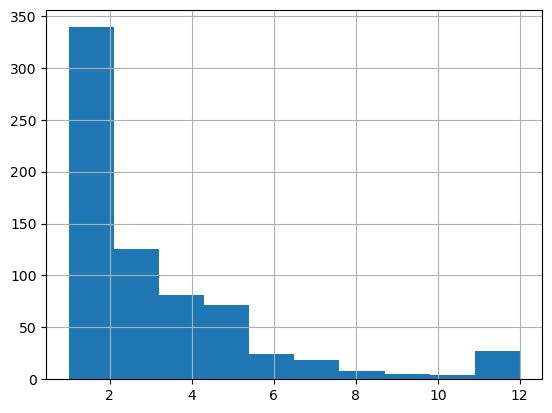

In [2139]:
tt[["CDR3a_extended", "CDR3b_extended"]].value_counts().hist()

<AxesSubplot:xlabel='CDR3a_extended,CDR3b_extended'>

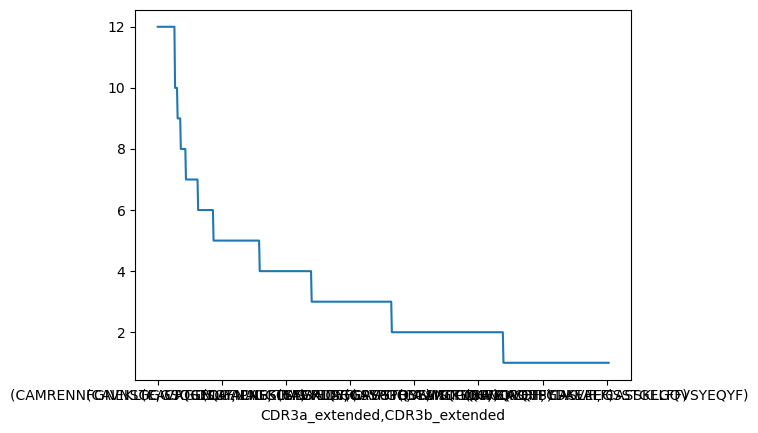

In [2140]:
tt[["CDR3a_extended", "CDR3b_extended"]].value_counts().plot()

## Peptide vs repetitions

In [2079]:
tt = test[test.Peptide.isin(train_vdjdb.Peptide)]

In [2080]:
def get_counts(tt):

    vc = tt[cdrcols].value_counts().reset_index().rename(columns={0: 'count'})

    peplist = []
    for c, sdf in vc.groupby('count'):
        pep = tt.set_index(cdrcols).Peptide.loc[pd.MultiIndex.from_frame(sdf)]
        pep.name = str(c)
        peplist.append(pep.value_counts())

    counts = pd.concat(peplist, axis=1).fillna(0).astype(int)

    return counts

In [2081]:
tt.Peptide.value_counts()

GILGFVFTL      526
RAKFKQLL       362
EPLPQGQLTAY    288
NLVPMVATV      258
YVLDHLIVV      204
VTEHDTLLY      150
GLCTLVAML      144
RPHERNGFTVL    114
IPSINVHHY       96
QIKVRVDMV       96
RPPIFIRRL       90
IVTDFSVIK       84
TPRVTGGGAM      78
YLQPRTFLL       78
Name: Peptide, dtype: int64

In [2082]:
get_counts(tt).loc[tt.Peptide.value_counts().index]

,1,2,3,4,5,6,7,8,9,10,11,12,14
GILGFVFTL,93,119,81,72,58,26,19,15,4,4,5,3,27
RAKFKQLL,28,81,59,54,47,16,19,13,6,4,5,3,27
EPLPQGQLTAY,9,32,52,58,47,15,16,14,6,4,5,3,27
NLVPMVATV,7,16,39,56,47,17,15,15,6,4,6,3,27
YVLDHLIVV,6,12,36,18,41,16,16,14,6,4,5,3,27
VTEHDTLLY,2,6,20,23,14,16,14,10,6,4,5,3,27
GLCTLVAML,3,13,18,9,17,14,15,11,4,4,6,3,27
RPHERNGFTVL,1,11,13,11,12,9,3,12,3,4,5,3,27
IPSINVHHY,1,6,8,11,10,9,3,7,4,3,4,3,27
QIKVRVDMV,0,5,8,10,10,11,4,7,4,3,4,3,27


In [2083]:
get_counts(synthetic_test).loc[synthetic_test.Peptide.value_counts().index]

,1,2,3,4,5,6,7,8
GILGFVFTL,91,74,95,95,37,20,7,2
RAKFKQLL,52,47,75,66,28,17,7,2
IVTDFSVIK,61,40,48,60,29,11,8,1
NLVPMVATV,31,18,49,54,24,14,2,0
GLCTLVAML,24,20,41,47,17,18,5,2
YVLDHLIVV,7,17,28,42,20,10,7,1
YLQPRTFLL,27,14,20,30,20,4,3,2
TPRVTGGGAM,13,16,26,29,14,11,3,2
RPPIFIRRL,13,13,16,25,20,8,6,1
VTEHDTLLY,13,7,22,27,18,9,4,2


In [2084]:
# synthetic_test = pep_sample_negatives2(train_vdjdb, test)

In [2085]:
pp = np.intersect1d(tt.Peptide, synthetic_test.Peptide)

In [2086]:
pp = synthetic_test.Peptide.value_counts().index

In [2087]:
pd.concat([synthetic_test.Peptide.value_counts()[pp], tt.Peptide.value_counts()[pp]], axis=1)

,Peptide,Peptide
GILGFVFTL,421,526
RAKFKQLL,294,362
IVTDFSVIK,258,84
NLVPMVATV,192,258
GLCTLVAML,174,144
YVLDHLIVV,132,204
YLQPRTFLL,120,78
TPRVTGGGAM,114,78
RPPIFIRRL,102,90
VTEHDTLLY,102,150


In [2088]:
synthetic_test.Peptide.value_counts().shape

(11,)

In [2089]:
synthetic_test[synthetic_test.y==1].Peptide.value_counts()

GILGFVFTL      94
RAKFKQLL       49
IVTDFSVIK      43
NLVPMVATV      32
GLCTLVAML      29
YVLDHLIVV      22
YLQPRTFLL      20
TPRVTGGGAM     19
RPPIFIRRL      17
VTEHDTLLY      17
RPHERNGFTVL    15
Name: Peptide, dtype: int64

## Exit time analysis

In [2107]:
from collections import defaultdict

def exit_time_analysis(tt):
    
    vc = tt[cdrcols].value_counts()

    p_old = None
    pep_counts = defaultdict(set)
    for (cdra, cdrb), v in vc.iteritems():
        p_current = tt.query(f'CDR3a_extended == "{cdra}" and CDR3b_extended == "{cdrb}"').Peptide.unique()
        for p in p_current:
            pep_counts[p].add(v)
        if p_old is not None:
            missing = np.setdiff1d(p_old, p_current)
            new = np.setdiff1d(p_current, p_old)
            print(len(p_old), len(p_current), missing, new, v)
            # if len(diff) > 0:
            #     print(diff)

        p_old = p_current
    return pep_counts

In [2108]:
r = exit_time_analysis(tt)

14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 12 ['TPRVTGGGAM' 'YLQPRTFLL'] [] 12
12 12 [] [] 12
12 12 [] [] 12
12 11 ['RPPIFIRRL'] [] 11
11 11 ['IVTDFSVIK'] ['RPPIFIRRL'] 11
11 11 [] [] 11
11 11 [] [] 11
11 9 ['IPSINVHHY' 'QIKVRVDMV'] [] 11
9 10 ['RPPIFIRRL'] ['IPSINVHHY' 'QIKVRVDMV'] 10
10 10 [] [] 10
10 10 [] [] 10
10 10 ['IPSINVHHY' 'QIKVRVDMV'] ['TPRVTGGGAM' 'YLQPRTFLL'] 10
10 9 ['RPHERNGFTVL' 'TPRVTGGGAM' 'YLQPRTFLL'] ['IPSINVHHY' 'QIKVRVDMV'] 9
9 9 ['GLCTLVAML'] ['IVTDFSVIK'] 9
9 9 ['IPSINVHHY' 'QIKVRVDMV'] ['GLCTLVAML' 'RPHERNGFTVL'] 9
9 9 ['GLCTLVAML' 'IVTDFSVIK'] ['IPSINVHHY' 'QIKVRVDMV'] 9
9 9 ['GILGFVFTL' 'IPSINVHHY' 'QIKVRVDMV' 'RPH

In [2109]:
r

defaultdict(set,
            {'RAKFKQLL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'RPHERNGFTVL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'EPLPQGQLTAY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'NLVPMVATV': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'IVTDFSVIK': {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14},
             'QIKVRVDMV': {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'IPSINVHHY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'GILGFVFTL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'YVLDHLIVV': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'YLQPRTFLL': {2, 3, 4, 5, 6, 7, 8, 9, 10, 14},
             'TPRVTGGGAM': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14},
             'GLCTLVAML': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'RPPIFIRRL': {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 14},
             'VTEHDTLLY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}})

In [2110]:
r2 = exit_time_analysis(synthetic_test)

8 8 ['IVTDFSVIK' 'RPHERNGFTVL'] ['RPPIFIRRL' 'YVLDHLIVV'] 8
8 7 ['GLCTLVAML' 'TPRVTGGGAM' 'YLQPRTFLL'] ['IVTDFSVIK' 'RPHERNGFTVL'] 7
7 7 ['RPHERNGFTVL' 'VTEHDTLLY' 'YVLDHLIVV'] ['GLCTLVAML' 'NLVPMVATV' 'YLQPRTFLL'] 7
7 7 ['NLVPMVATV' 'RAKFKQLL' 'RPPIFIRRL'] ['RPHERNGFTVL' 'VTEHDTLLY' 'YVLDHLIVV'] 7
7 7 ['GLCTLVAML' 'YLQPRTFLL'] ['RAKFKQLL' 'RPPIFIRRL'] 7
7 7 ['GILGFVFTL' 'VTEHDTLLY'] ['GLCTLVAML' 'TPRVTGGGAM'] 7
7 7 ['GLCTLVAML' 'RPHERNGFTVL' 'RPPIFIRRL'] ['GILGFVFTL' 'NLVPMVATV' 'YLQPRTFLL'] 7
7 7 ['NLVPMVATV' 'TPRVTGGGAM' 'YLQPRTFLL'] ['GLCTLVAML' 'RPPIFIRRL' 'VTEHDTLLY'] 7
7 7 ['VTEHDTLLY'] ['TPRVTGGGAM'] 7
7 6 ['GLCTLVAML' 'IVTDFSVIK' 'RPPIFIRRL' 'TPRVTGGGAM' 'YVLDHLIVV'] ['NLVPMVATV' 'RPHERNGFTVL' 'VTEHDTLLY' 'YLQPRTFLL'] 6
6 6 ['RAKFKQLL' 'YLQPRTFLL'] ['GLCTLVAML' 'IVTDFSVIK'] 6
6 6 ['NLVPMVATV' 'VTEHDTLLY'] ['RAKFKQLL' 'YVLDHLIVV'] 6
6 6 ['GILGFVFTL' 'YVLDHLIVV'] ['TPRVTGGGAM' 'VTEHDTLLY'] 6
6 6 ['IVTDFSVIK' 'RPHERNGFTVL' 'VTEHDTLLY'] ['GILGFVFTL' 'YLQPRTFLL' 'YVLDHLIVV'] 6
6 6 

In [2111]:
r2

defaultdict(set,
            {'GILGFVFTL': {1, 2, 3, 4, 5, 6, 7, 8},
             'GLCTLVAML': {1, 2, 3, 4, 5, 6, 7, 8},
             'IVTDFSVIK': {1, 2, 3, 4, 5, 6, 7, 8},
             'RAKFKQLL': {1, 2, 3, 4, 5, 6, 7, 8},
             'RPHERNGFTVL': {1, 2, 3, 4, 5, 6, 7, 8},
             'TPRVTGGGAM': {1, 2, 3, 4, 5, 6, 7, 8},
             'VTEHDTLLY': {1, 2, 3, 4, 5, 6, 7, 8},
             'YLQPRTFLL': {1, 2, 3, 4, 5, 6, 7, 8},
             'RPPIFIRRL': {1, 2, 3, 4, 5, 6, 7, 8},
             'YVLDHLIVV': {1, 2, 3, 4, 5, 6, 7, 8},
             'NLVPMVATV': {1, 2, 3, 4, 5, 6, 7}})

## Length distribution plots

In [2120]:
def plot_length(train, test, col):
    N = 10
    fig, axs = plt.subplots(nrows=N // 5, ncols=5)
    axs = axs.flat
    peps = train[train.Peptide.isin(test.Peptide)].Peptide.value_counts().index
    for i, p in enumerate(peps[:N]):
        ax = axs[i]
        t = test[test.Peptide == p]
        t[col].str.len().hist(ax=ax, density=True, alpha=0.7, label=f"{col} test", bins=np.arange(9, 22))
        # t.CDR3b_extended.str.len().hist(ax=ax, alpha=0.7, label='beta test')

        tr = train[train.Peptide == p]
        tr[col].str.len().hist(ax=ax, density=True, alpha=0.7, label=f"{col} train", bins=np.arange(9, 22))
        # tr.CDR3b_extended.str.len().hist(ax=ax, alpha=0.7, label='beta train')
        if i == 0:
            ax.legend()
        ax.set_title(f"{p} {len(t)} {len(tr)}")

    fig.set_size_inches(16, 9)

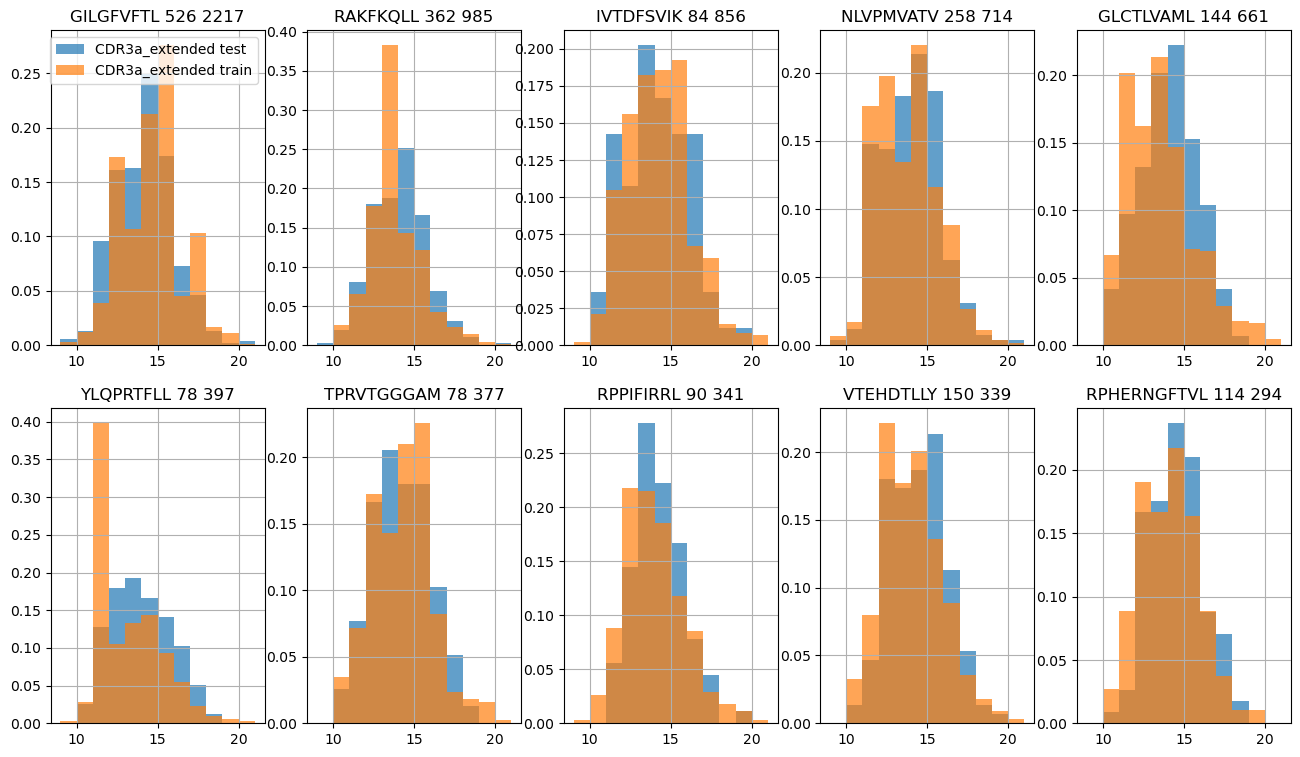

In [2123]:
plot_length(train_immuno, test, 'CDR3a_extended')

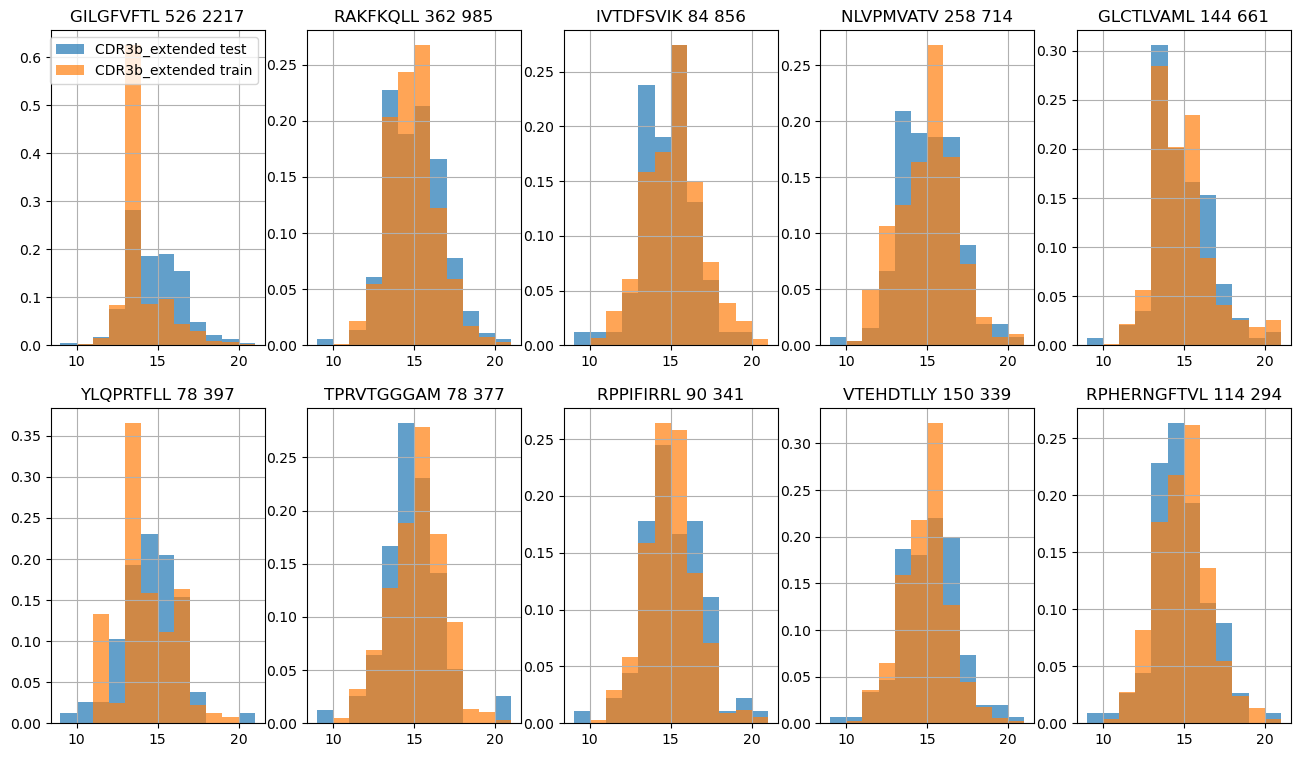

In [2124]:
plot_length(train_immuno, test, 'CDR3b_extended')

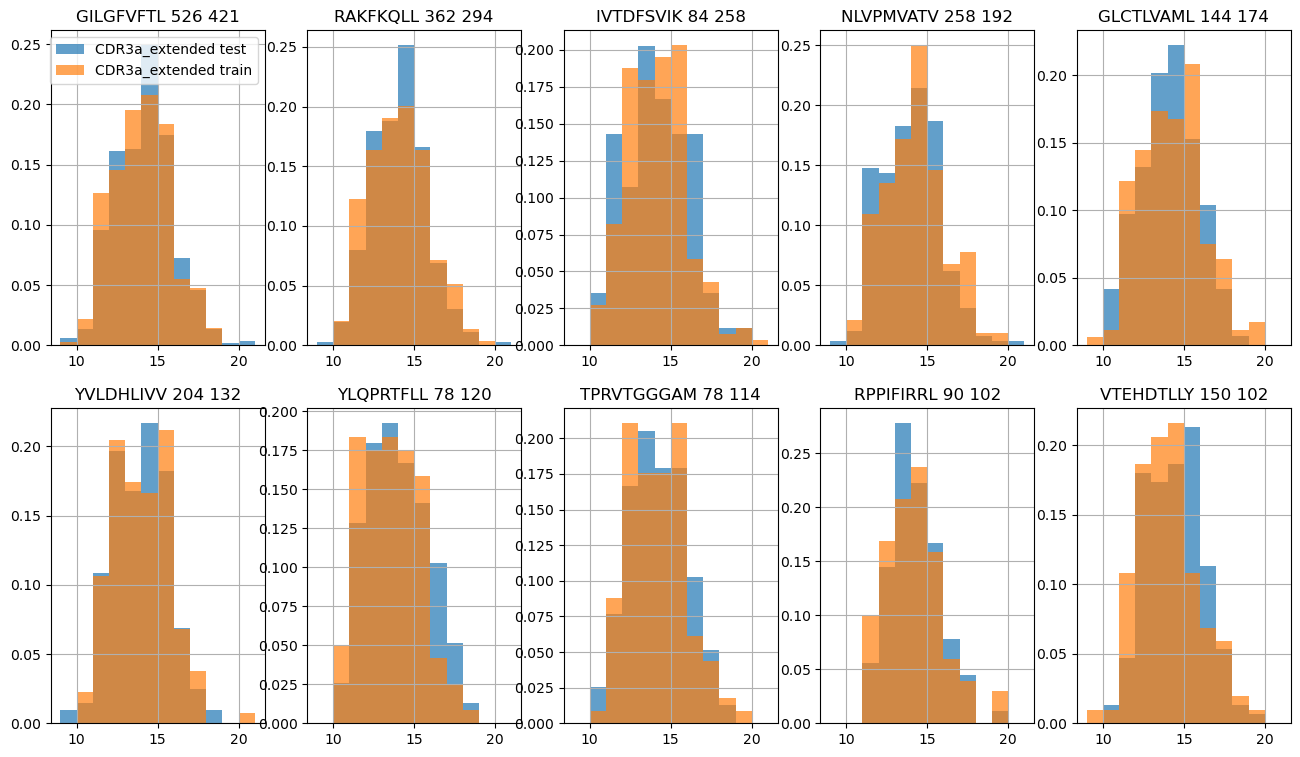

In [2125]:
plot_length(synthetic_test, test, 'CDR3a_extended')

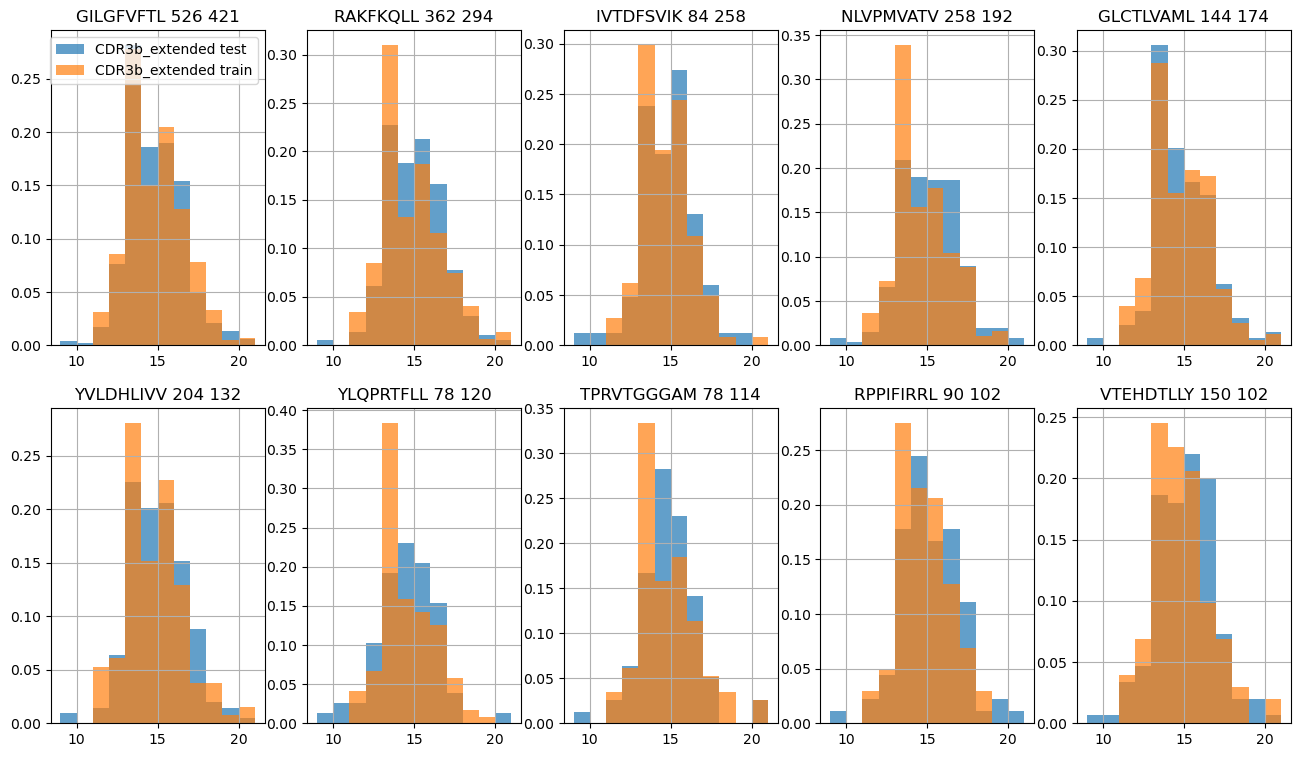

In [2126]:
plot_length(synthetic_test, test, 'CDR3b_extended')

# Non-binders

In [2]:
nb = pd.read_parquet(
    "/mnt/flash/AImmune/pHLA-TCR/data-curation/prod/1.4.0/no-binding-concatenation/no-binding-concatenation"
)

In [8]:
ref_ab = nb[~nb.CDR3_alpha.isna() & ~nb.CDR3_beta.isna()]

In [9]:
ref_ab.shape

(273393, 43)

In [ ]:
ref_ab.CDR3_alpha.isin(alpha_b

In [6]:
nb.sample().iloc[0]

donor_id                                                                   0
reference_id                             https://doi.org/10.1093/nar/gkaa796
barcode                                               654559#tcrdb_chunk_0.n
TRA                                                                     None
TRAV                                                                    None
TRAV_original                                                           None
TRAV_L1                                                                 None
TRAV_L2                                                                 None
TRAV_seq                                                                None
TRAJ                                                                    None
TRAJ_original                                                           None
TRAJ_L1                                                                 None
TRAJ_L2                                                                 None

In [17]:
alpha_beta_binders.sample().iloc[0]

CDR3_alpha                                                     CAVDMDSSYKLIF
CDR3_beta                                                       CASSSNTGEQFF
TRBV                                                             TRBV12-3*01
TRBJ                                                              TRBJ2-1*01
TRAV                                                             TRAV12-2*01
TRAJ                                                               TRAJ12*01
antigen_origin                                                        Cancer
pHLA                                                         A1101_HTMGFWLTK
Peptide                                                            HTMGFWLTK
HLA                                       YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY
donor_id                                                                  12
reference_id                                        ardigen_healthy/donor_12
meta_donor_MHC                                                           nan

In [6]:
# df_pos = read_positives_and_group_by_tcr('../../data/phla_tcr_all.csv.gz')

In [15]:
ref_tcrs_oakes = read_reference_tcrs("../../data/oakes_tcr_repertoires/")

INFO:root:Reading reference TCRs from ../../data/oakes_tcr_repertoires/


In [16]:
ref_tcrs_oakes.shape

(574382,)

In [17]:
ref_tcrs_oakes.unique().shape

(521753,)

In [19]:
ref_tcrs_oakes = ref_tcrs_oakes.drop_duplicates()

In [20]:
ref_tcrs_oakes.shape

(521753,)

In [22]:
regex = f"[{''.join(AA_list)}]+"
regex

'[ACDEFGHIKLMNPQRSTVWY]+'

In [27]:
def basic_filtering(cdrs):
    return cdrs[
        (~cdrs.isin(df_pos.CDR3b))
        & (~cdrs.isin(ref_tcrs_oakes))
        & (cdrs.str.len().isin(range(10, 21)))
        & (cdrs.str[0] == "C")
        & cdrs.str.fullmatch(regex)
    ]

In [28]:
ref_tcrs_oakes.shape

(521753,)

In [25]:
# ref_tcrs_oakes = basic_filtering(ref_tcrs_oakes)
# ref_tcrs_oakes.shape

In [19]:
# cellranger_base_dir = '/mnt/storage2/immuno/DATA/single-cell-TCR-generation-datasets/output/cellranger'

# cdrs = []
# for vdj_annot_fn in glob.glob(os.path.join(cellranger_base_dir, '*/outs/all_contig_annotations.csv')):
#     df = pd.read_csv(vdj_annot_fn)
#     # df_cdr3b = df[(df.chain == 'TRB') & df.high_confidence & df.is_cell & df.full_length & df.productive]
#     df_cdr3b = df[(df.chain == 'TRB')]
#     cdrs.append(df_cdr3b.cdr3)

# cdrs = pd.concat(cdrs).reset_index(drop=True)

# len(cdrs)

# cdrs.unique().shape

In [1]:
import pandas as pd

In [2]:
ref_tcrs_carter = pd.read_pickle("/home/ardigen/Downloads/CD8_sequences.pkl")

In [3]:
ref_tcrs_carter.shape

(26946, 8)

In [4]:
ref_tcrs_carter.iloc[0]

Va                   1-1
Ja                    12
Vb                    27
Jb                   2-7
CDR3a      CAGEMDSSYKLIF
CDR3b       CASSPTMNEQYF
Subject                0
Method              Juno
Name: 0, dtype: object

In [37]:
!ls ../../data/dean_tcr_repertoires/

0.15384615384615385

In [47]:
all_tcrs = pd.concat(tcr_list)

In [48]:
all_tcrs.shape

(14725598,)

In [49]:
all_tcrs.value_counts()

CASSLQGGNTEAFF       76
CASSPDRDYGYTF        76
CASSLGQGGETQYF       75
CASSRQGSNQPQHF       75
CASSLTGYGYTF         74
                     ..
CASSLQNGPGFF          1
CASSAPAGGFSTDTQYF     1
CASRIYRGDTEAFF        1
CASSRDRGFGNYEQYF      1
CATGAYNEQSF           1
Name: aminoAcid, Length: 11407093, dtype: int64

In [50]:
unique_tcrs = all_tcrs.drop_duplicates()

In [51]:
unique_tcrs.shape

(11407093,)

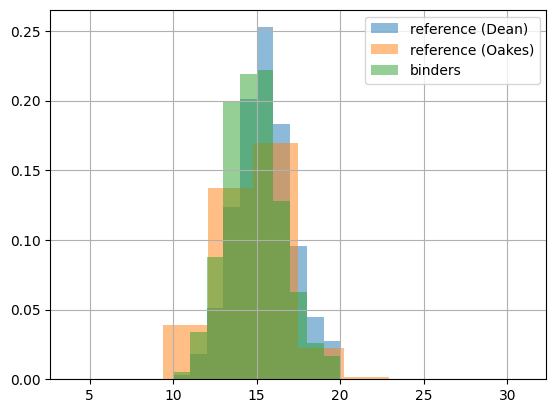

In [54]:
ax = plt.gca()
unique_tcrs.str.len().hist(ax=ax, density=True, alpha=0.5, label="reference (Dean)")
ref_tcrs_oakes.str.len().hist(ax=ax, density=True, alpha=0.5, label="reference (Oakes)")
df_pos.CDR3b.str.len().hist(ax=ax, density=True, alpha=0.5, label="binders")
plt.legend()
plt.show()

In [47]:
def downsample_length(dataset, frac=1):
    pos = dataset[dataset.y == 1]
    neg = dataset[dataset.y == 0]

    pos_count = pos.CDR3b.str.len().value_counts().sort_index()
    neg_count = neg.CDR3b.str.len().value_counts().sort_index()

    ratio = pos_count / neg_count
    max_ratio = ratio.max()

    to_remove = round((neg_count * (max_ratio - ratio)) / max_ratio).astype(int)
    to_sample = neg_count - to_remove

    neg_samples = []
    for length, n_to_sample in to_sample.iteritems():
        neg_sample = neg[neg.CDR3b.str.len() == length].sample(int(n_to_sample * frac), random_state=42)
        neg_samples.append(neg_sample)
    dataset_downsampled = pd.concat([pos] + neg_samples)
    return dataset_downsampled

In [52]:
unique_tcrs.shape

(11407093,)

In [56]:
ref_tcrs_dean = basic_filtering_bertrand(unique_tcrs, df_pos)

INFO:root:Basic filtering: started with 11407093 reference TCRs, 11407093 after filtering


In [57]:
ref_tcrs_dean = ref_tcrs_dean.rename(columns={"CDR3b": "junction_aa"}).drop(columns="y")

In [58]:
ref_tcrs_dean.sample(5)

,junction_aa
1915758,CASSLADLGGLEQYF
453050,CASRYGGSSDTQYF
2007832,CASSTAGPPQFWAGTDTQYF
7020283,CASSFVRLEQFF
4305700,CASSEAQGAEETQYF


In [61]:
ref_tcrs_dean.to_csv("../../data/dean_tcr_repertoires/dean_downsampled_11M.csv.gz")

In [62]:
d = pd.read_csv("../../data/presented_peptides.csv.gz", index_col=0)

In [63]:
d.head()

,HLA_type,Peptide2,is_presented
abelin_pos_1,A02:01,KLWEMDNMLI,1
abelin_pos_2,A02:03,KLYDIDVAKV,1
abelin_pos_4,A02:07,QVDDLKAKL,1
abelin_pos_6,A24:02,AYVHMVTHF,1
abelin_pos_10,B35:01,LPDEIYHVY,1


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../data/dean_tcr_repertoires/dean_downsampled_11M.csv.gz")

In [3]:
df.shape

(11407093, 2)

In [4]:
df2 = pd.read_csv("/mnt/storage2/olek/bertrand-rep3/pretraining/mlm_train.csv.gz")

In [5]:
df2.shape

(9125674, 4)

In [6]:
df3 = pd.read_csv("/mnt/storage2/olek/bertrand-rep3/pretraining/mlm_val.csv.gz")

In [7]:
df3.shape

(2281419, 4)